# Density Module - GaussianDensity
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles.
In this notebook, we demonstrate `freud`'s Gaussian density calculation, which provides a way to interpolate particle configurations onto a regular grid in a meaningful way that can then be processed by other algorithms that require regularity, such as a [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fft).

In [1]:
import numpy as np
from scipy import stats
import freud
import util
from helper_functions.box_plotting import box_2d_to_points
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define some helper plotting functions.
def plot_lattice(box, points, size=1500):
    """Helper function for plotting points on a lattice."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    box_points = box_2d_to_points(box)
    ax.plot(box_points[:, 0], box_points[:, 1], color='k')
    
    ax.scatter(points[:, 0], points[:, 1], s=size, marker='o',
               facecolors='None', linestyle='--',
               edgecolors=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
    return fig, ax

def plot_rdf(box, points, prop, rmax = 3, drs = [0.15, 0.04, 0.001]):
    """Helper function for plotting RDFs."""
    fig, axes = plt.subplots(1, len(drs), figsize=(16, 3))
    for i, dr in enumerate(drs):
        rdf = freud.density.RDF(rmax, dr)
        rdf.compute(box, points)
        axes[i].plot(rdf.R, getattr(rdf, prop))
        axes[i].set_title("Bin width: {:.3f}".format(dr), fontsize=16)
    return fig, ax

To illustrate the basic concept, consider a toy example: a simple set of point particles with unit mass on a line.
For analytical purposes, the standard way to accomplish this would be using [Dirac delta functions](https://en.wikipedia.org/wiki/Dirac_delta_function).

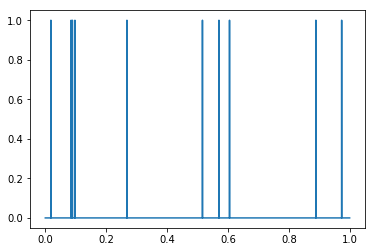

In [3]:
n_p = 10000
np.random.seed(129)
x = np.linspace(0, 1, n_p)
y = np.zeros(n_p)
points = np.random.rand(10)
y[(points*n_p).astype('int')] = 1
plt.plot(x, y);

However, delta functions can be cumbersome to work with, so we might instead want to smooth out these particles
One option is to instead represent particles as Gaussians centered at the location of the points.
In that case, the total particle density at any point in the interval $[0, 1]$ represented above would be based on the sum of the densities of those Gaussians at those points.

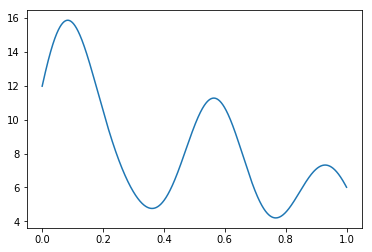

In [4]:
# Note that we use a Gaussian with a small standard deviation
# to emphasize the differences on this small scale
dists = [stats.norm(loc=i, scale=0.1) for i in points]
y_gaussian = 0
for dist in dists:
    y_gaussian += dist.pdf(x)
plt.plot(x, y_gaussian);

The goal of the GaussianDensity class is to perform the same interpolation for points on a 2D or 3D grid, accounting for Box periodicity.

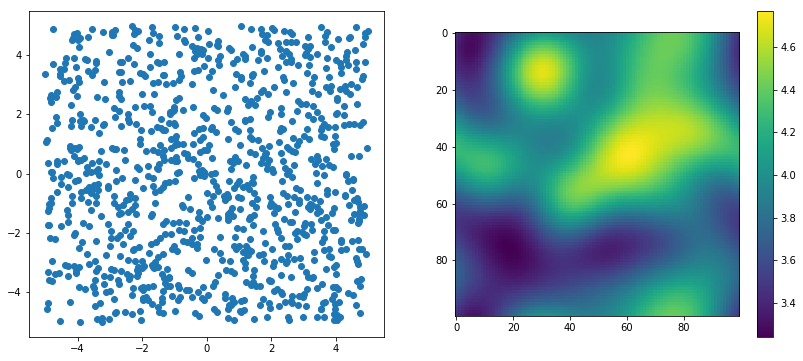

In [5]:
N = 1000  # Number of points
L = 10  # Box length
box = freud.box.Box.square(L)
points = box.wrap(np.random.rand(N, 3)*L)
points[:, 2] = 0
gd = freud.density.GaussianDensity(L*L, L/3, 1)
gd.compute(box, points)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(points[:, 0], points[:, 1])
im = axes[1].imshow(gd.gaussian_density);
plt.colorbar(im);

The effects are much more striking if we explicitly construct our points to be centered at certain regions.

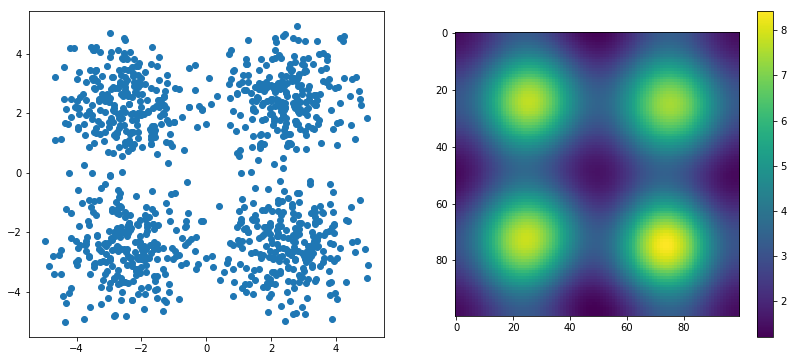

In [6]:
N = 1000  # Number of points
L = 10  # Box length
box = freud.box.Box.square(L)
centers = np.array([[L/4, L/4, 0],
                    [-L/4, L/4, 0],
                    [L/4, -L/4, 0],
                    [-L/4, -L/4, 0]])

points = []
for center in centers:
    points.append(np.random.multivariate_normal(center, cov=np.eye(3, 3), size=(int(N/4),)))
points = box.wrap(np.concatenate(points))
points[:, 2] = 0

gd = freud.density.GaussianDensity(L*L, L/3, 1)
gd.compute(box, points)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(points[:, 0], points[:, 1])
im = axes[1].imshow(gd.gaussian_density);
plt.colorbar(im);